In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import shap

# Load dataset (Replace 'your_dataset.csv' with the actual file path)
file_path = "/content/customer_booking.csv"
df = pd.read_csv(file_path, encoding="Latin")

# Optimize memory usage
for col in df.select_dtypes(include=['int64', 'float64']).columns:
    df[col] = df[col].astype('float32')

# Data Exploration
print(df.info(memory_usage='deep'))  # Show memory usage
print(df.describe())
print(df.isnull().sum())  # Check missing values


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  float32
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  float32
 4   length_of_stay         50000 non-null  float32
 5   flight_hour            50000 non-null  float32
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  float32
 10  wants_preferred_seat   50000 non-null  float32
 11  wants_in_flight_meals  50000 non-null  float32
 12  flight_duration        50000 non-null  float32
 13  booking_complete       50000 non-null  float32
dtypes: float32(9), object(5)
memory usage: 16.9 MB
None
  

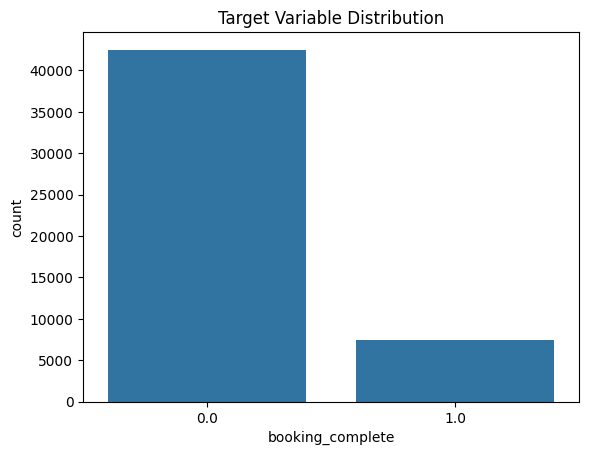

RandomForestClassifier(n_jobs=-1, random_state=42)

In [2]:
# Visualize target variable distribution
sns.countplot(x='booking_complete', data=df)
plt.title('Target Variable Distribution')
plt.show()

# Convert categorical variables to 'category' dtype for efficiency
categorical_cols = ['sales_channel', 'trip_type', 'route', 'booking_origin', 'flight_day']
for col in categorical_cols:
    df[col] = df[col].astype('category')

# Encode categorical variables using Label Encoding
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store encoder for later use

# Define features (X) and target (y)
y = df['booking_complete']  # Target variable
X = df.drop(columns=['booking_complete'])  # Drop target column

# Use a sample for faster testing (remove for full training)
X_sample, y_sample = X.sample(10000, random_state=42), y.sample(10000, random_state=42)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

# Train a RandomForest Model
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)  # Use all CPU cores
model.fit(X_train, y_train)



Accuracy: 0.8515
Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.98      0.92      1709
         1.0       0.44      0.07      0.12       291

    accuracy                           0.85      2000
   macro avg       0.65      0.53      0.52      2000
weighted avg       0.80      0.85      0.80      2000

Confusion Matrix:
 [[1682   27]
 [ 270   21]]


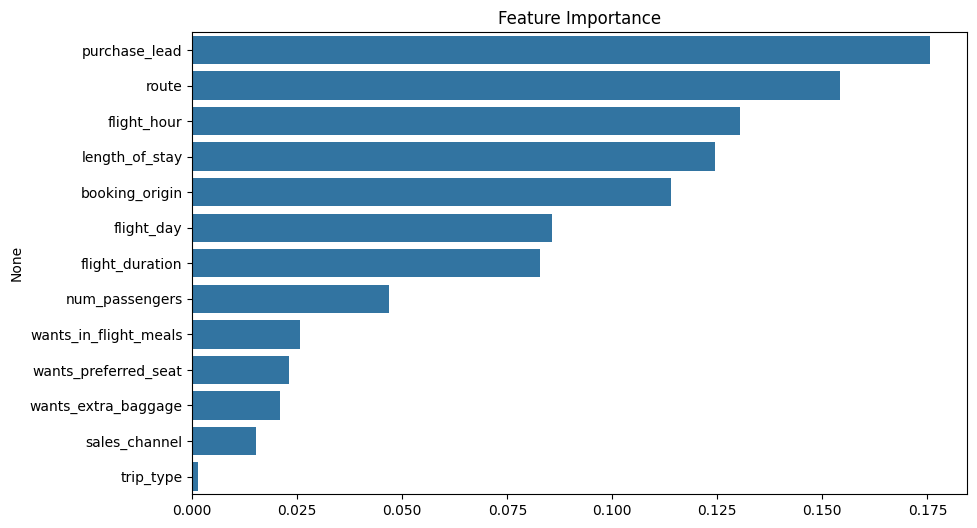

In [3]:
# Model Evaluation
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Feature Importance Visualization
importances = model.feature_importances_
feature_names = X.columns
sorted_indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[sorted_indices], y=feature_names[sorted_indices])
plt.title('Feature Importance')
plt.show()



<Figure size 640x480 with 0 Axes>

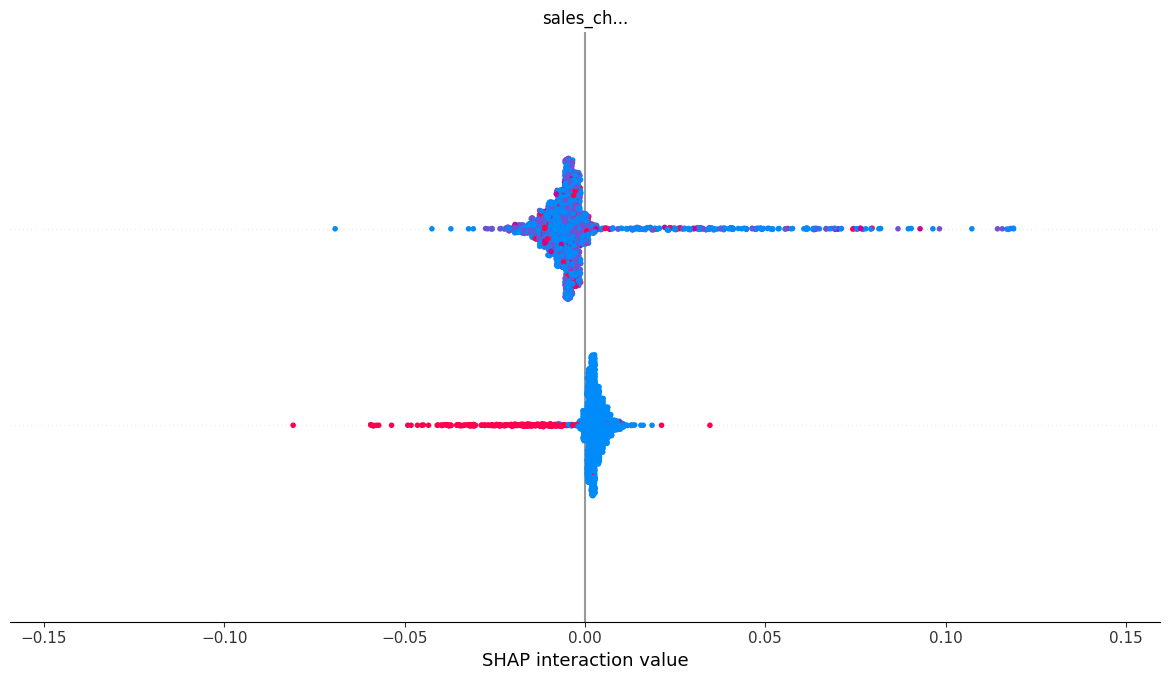

In [4]:
# SHAP Analysis for Interpretability
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
